# Plot diversity error maps of candidates selection

Step of the codes :
- Import modules 
- Define settings 
- Define functions 
- Download pc p1, pc pred, pc optim and pc obs
- Get candidates emulations
- Download EOF solver
- Download candidates data 
- Project candidates on EOF basis and get pseudo-pcs 
- Compute errors 
- Plot figure

# Import Module

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof
import random

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm
from cartopy.util import add_cyclic_point

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from sklearn.decomposition import PCA

# tqdm + Remove warnings
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

/data/scratch/globc/peatier/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Settings

### Variables

In [2]:
variables = ['tas']
var = 'tas'
variable = 'tas'
trunc = 18
TITLE = 'Surface Temperature'
ylabel = '$E_{tas}$ ($K$)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/PPE/CNRM-CM6-1_PPE/'
path_files='/data/scratch/globc/peatier/HOME_files/PPE/CNRMppe_error_decomposition/files/'
path_file_npy = '/data/scratch/globc/peatier/HOME_files/PPE/ENSEMBLE2/files/npy/'

# Functions

In [4]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

In [5]:
def MSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = (diff_tmp.sum(['lat', 'lon']))
    return diff

In [6]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [7]:
def MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = MSE(mod, obs, W_rmse_2D)
    return diff

In [8]:
def MultiLinReg_pred(LHS, X ,y, param_names) :

    LHS_df = pd.DataFrame(LHS)

    lhs = LHS_df.values
    #LHS_df

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    N=len(LHS_df.values)
    tmp = [0]*N
    y_pred = [0]*N
    i=0
    Ycpt=0
    while i<N:
        
        tmp[i] = Coeffs.values*LHS_df.iloc[i]
        y_pred[i] = tmp[i].sum()+R
        i+=1

    #y_pred
    #members = arange(102,100102,1)
    #DFYpred = pd.DataFrame([y_pred, members], index=["y_pred", "members"]).transpose()
    return y_pred

# Get data 

In [9]:
path_file = path_files+'npy/'
filename = 'CNRMppe_decomposition_mean_'+str(variable)+'.npy'
Mean =  pd.read_pickle(path_file+filename).to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})

In [10]:
W_eof_2D = np.load(path_files+'npy/W_eof_2D_'+str(variable)+'.npy')
W_eof_3D = np.load(path_files+'npy/W_eof_3D_'+str(variable)+'.npy')
W_rmse_2D = np.load(path_files+'npy/W_rmse_2D_'+str(variable)+'.npy')

### BEST observations

In [11]:
path_observation = '/data/scratch/globc/peatier/obs/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'
var = 'tas'

In [12]:
# POUR LES OBSERVATIONS BEST

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['temperature'] = df_obs['temperature']
df_obs['clim'] = clim['climatology']
df_obs['tas'] = df_obs['temperature']+df_obs['clim']+273.15
variable_obs = 'ta'

In [13]:
obs = {}
obs[var] = df_obs[var].groupby(['lat','lon']).mean().to_xarray()

In [14]:
## --Observations
X_obs = obs[var] - Mean
X_obs_w = X_obs*W_eof_2D

# Download PCs

In [15]:
#path_files = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'

## PPE
path = path_files+'nc/'
filename = 'pc_PPE_'+var+'.nc'
pc_PPE = xr.open_mfdataset(path+filename,combine='by_coords')
dims_dict = {'time' : 'members', 'mode' : 'modes'}
pc_PPE = pc_PPE.rename_dims(dims_dict)
    
## observations
path = path_files+'nc/'
filename = 'pc_obs_'+var+'.nc'
pc_obs = xr.open_mfdataset(path+filename,combine='by_coords')
    
## p1 - the first line of pc_PPE
pc_p1 = pc_PPE['pcs'][0,:]
    
## predictions
path = path_files+'nc/'
filename = 'pc_pred_'+var+'.nc'
pc_pred = xr.open_mfdataset(path+filename,combine='by_coords')
pc_pred = pc_pred.rename({'__xarray_dataarray_variable__' : 'pcs'})

## eumlated candidates 
path = path_files+'nc/'
filename = 'PC_candidates_'+var+'_uni_kmedian.nc'
pc_cand_emul = xr.open_mfdataset(path+filename,combine='by_coords')
pc_cand_emul = pc_cand_emul.rename({'__xarray_dataarray_variable__' : 'pcs'})

In [16]:
#path_files = '/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'
path = path_files+'nc/'
filename = 'optim_pc_PPE_'+var+'.nc'
pc_optim = xr.open_mfdataset(path+filename,combine='by_coords')

In [17]:
df_optim = pd.DataFrame()
for i in range(1,trunc+1,1) :
    df_optim['EOF '+str(i)] = pc_optim['EOF '+str(i)].values
df_optim['LHS index'] = pc_optim['LHS index'].values

# Download EOF solver

In [18]:
import pickle
path = path_files+'pkl/'

# open a file, where you stored the pickled data
file = open(path+'solver_'+var+'.pkl', 'rb')

# dump information to that file
solver = pickle.load(file)

# close the file
file.close()

In [19]:
eofs = {}
variances = {}
eofs = solver.eofsAsCovariance(pcscaling=1)
variances = solver.varianceFraction() 

In [20]:
# Reference simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = 'tas_*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, ['tas'])

In [21]:
lat = p1_amip['lat']
lon = p1_amip['lon']
eofs_nb = arange(1,104,1)
eofs_xr = {}
eofs_combined = {}

eofs_xr = xr.DataArray(eofs, 
                   coords={'eofs': eofs_nb,'lat': lat,'lon': lon}, 
                   dims=["eofs", "lat", "lon"])#.to_dataset(name=var)
## --Combine the modes for reconstruction
eofs_combined = eofs_xr

## Analysis of CNRM-CM candidates runs

In [22]:
nb_p_select = ['p970', 'p971', 'p972', 'p973', 'p974', 
               'p975', 'p976', 'p977', 'p979', 'p980',
                'p981']

In [23]:
## -- CNRM-CM candidates simulations :
filename='*_amip_*.nc'
path_ens = 'ENSEMBLE5/CNRM-CM6-1_amip_PPE_ENSEMBLE5/ESD_2024_select_k_median/select_tas/'
amip_select=[]
for p in tqdm(nb_p_select) :
    path=path_PPE+path_ens+'CNRM-CM6-1_amip_r1i1'+p+'f2/'
    amip_tmp = get_3D_tas_xarr(path, filename, variables)
    amip_select.append(amip_tmp)

100%|██████████| 11/11 [00:01<00:00,  8.88it/s]


In [24]:
## --Analysis of the candidates  :
var = 'tas'
U_sel_list = []
X_sel_rec_list = []
p_sel_list = []
e_sel_list = []

for X_sel in tqdm(amip_select) :
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
          
    ## -- Full error RMSE : 
    e_sel = MSE(X_sel, obs[var], W_rmse_2D)
    e_sel_list.append(e_sel)
    
    ## -- Project the candidates :
    X_sel_w = (X_sel - Mean)*W_eof_2D
    U_sel = solver.projectField(X_sel_w, neofs=trunc, weighted=False, eofscaling=1)
    U_sel_list.append(U_sel)
    
    ## --Reconstruct the candidates :
    X_sel_rec = reconstruct_X(eofs_combined[0:trunc], pc=U_sel[0:trunc], nb_dims=2)
    X_sel_rec_list.append(X_sel_rec)
    
    ## -- Reconstruct obs :
    pc=pc_obs['pseudo_pcs'][0:trunc]
    X_obs_rec = reconstruct_X(eofs_combined[0:trunc], pc, nb_dims=2)
    
    ## -- Parametric errors RMSE_rec : 
    p_sel = MSE_rec(X_sel_rec, X_obs_rec, Mean, W_rmse_2D)
    p_sel_list.append(float(p_sel))

100%|██████████| 11/11 [00:00<00:00, 14.07it/s]


In [25]:
## -- Faire DataFrame :
df_sel = pd.DataFrame([None]*len(nb_p_select), columns= ['index'])

for i in range(0,18,1) :
    U_sel_df = []
    for mb in range(0,len(nb_p_select),1) :
        U_sel_df.append(float(U_sel_list[mb][i]))
    
    df_sel['EOF '+str(i+1)] = U_sel_df
    
df_sel['p'] = p_sel_list
df_sel

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6  \
0   None -0.654848 -1.443328  0.446250  0.915321  0.981299  0.427429   
1   None -0.439338 -0.671463 -0.103887 -0.168686 -1.523956 -0.118120   
2   None -1.137770 -0.889979  0.412668 -0.607676 -0.833003  0.555838   
3   None -0.802284 -0.901894  0.818536 -0.318115 -1.517223 -0.806377   
4   None -0.374680 -2.243893  1.689583  1.378409  0.228512  1.828899   
5   None -0.990860 -2.081814  0.829666  0.981919 -1.118110  0.373762   
6   None -1.202389 -0.523375 -0.068662 -0.465762 -0.492641  0.801189   
7   None -0.249705  0.034528  0.121303 -0.608909 -0.620926 -0.431580   
8   None -0.421635 -1.383829 -0.591026 -0.385531 -2.118580 -0.472324   
9   None -0.262712 -1.132858 -0.585351 -1.511215 -2.335308  0.245879   
10  None -0.909385 -1.220372 -0.210379 -0.687049 -1.439420  1.028115   

       EOF 7     EOF 8     EOF 9    EOF 10    EOF 11    EOF 12    EOF 13  \
0  -1.004429  0.058288  0.060800  0.813852 -1.216157  0.945853  0.320825   
1   0.487045 -0.159394 -0.965439 -1.015203 -0.340848 -0.243244  1.363282   
2  -0.175107  1.025299  0.121478 -0.450598 -0.950316  0.663575 -0.713029   
3   0.023068 -0.808524  1.621510 -1.663582 -0.932900  0.054566  0.570481   
4  -1.354046 -0.372838 -0.155780  0.985018  0.330527  1.345726 -1.327052   
5  -0.666217 -0.482001 -1.308910  0.565484 -1.121515  1.465783 -0.096056   
6  -1.467949 -0.426708  0.529241 -1.917151 -1.101160  1.198596  0.640518   
7  -0.537785 -1.018427  1.164270 -0.009613 -0.281095  0.639826 -1.096978   
8  -2.430347 -1.061068 -1.260782 -0.125734 -0.126466  0.499638  1.645141   
9  -1.191126 -1.756378 -1.025725  0.314592 -0.545663 -0.280967  1.015900   
10 -0.465665 -1.672939 -1.818944 -1.323353  1.080883  1.348345  0.243656   

      EOF 14    EOF 15    EOF 16    EOF 17    EOF 18         p  
0   0.238728 -0.908515 -0.228015  0.050997 -1.241732  0.930681  
1   0.191840  0.655060 -1.191317  0.548761 -0.059298  0.649681  
2  -1.311406  0.373047 -0.420226 -0.504975 -0.214887  0.617569  
3   0.846179 -0.146720 -0.536581 -1.497693 -0.957029  0.719954  
4  -1.310833 -0.019013 -0.430334 -1.099575 -2.149230  0.982908  
5   1.089847  0.338566 -0.516066  1.163266 -0.510982  0.839279  
6  -0.681809 -0.232856  2.159721 -0.852695 -0.122145  0.984168  
7  -1.153153 -0.607771 -0.648611  0.310096 -0.998310  0.848599  
8   0.059546  0.137583  0.559062 -2.373862 -1.248080  0.954229  
9  -0.298634 -0.089100 -0.680227 -2.175791 -0.669033  0.882425  
10 -1.225647  1.201753 -0.616273 -0.239417  0.086910  0.822485

# Spatial maps CNRM-CM candidates

In [26]:
def diff_3D_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = mod - obs
    
    return diff
    

In [27]:
e_diff=[]
p_diff=[]
u_diff=[]
e_sel=[]
p_sel=[]
u_sel=[]

for X_sel in tqdm(amip_select) : 
    ## -- Because ARPEGE on Belenos does not have exactly the same grid as ARPEGE on Beaufix :
    X_sel['lat'] = eofs_combined['lat']
    X_sel['lon'] = eofs_combined['lon']
    
    ## -- 3D full error [obs - mod]
    e_diff_tmp = (X_sel - obs[var])
    e_diff.append(e_diff_tmp)
    
    diff_tmp = e_diff_tmp**2 * W_rmse_2D
    e_sel_tmp = float(diff_tmp.sum(['lat', 'lon']))
    e_sel.append(e_sel_tmp)
    
     ## -- Project the candidates :
    X_sel_w = (X_sel - Mean)*W_eof_2D
    U_sel = solver.projectField(X_sel_w, neofs=18, weighted=False, eofscaling=1)
    
    ## --Reconstruct the candidates :
    pc=U_sel[0:trunc]
    X_sel_rec = reconstruct_X(eofs_combined[0:trunc], pc, nb_dims=2)
    
    ## -- 3D p error [X_obs_rec - X_mod_rec]
    p_diff_tmp = diff_3D_rec(X_sel_rec, X_obs_rec, Mean, W_rmse_2D)
    p_diff.append(p_diff_tmp)
    
    diff_tmp = p_diff_tmp**2 * W_rmse_2D
    p_sel_tmp = float(diff_tmp.sum(['lat', 'lon']))
    p_sel.append(p_sel_tmp)
    
    ## -- 3D u error [e - p]
    u_diff_tmp = (e_diff_tmp - p_diff_tmp)
    u_diff.append(u_diff_tmp)
    
    diff_tmp = u_diff_tmp**2 * W_rmse_2D
    u_sel_tmp = float(diff_tmp.sum(['lat', 'lon']))
    u_sel.append(u_sel_tmp)
    
    ## -- Alternative to sanity check 
    #u_mod = X_sel

100%|██████████| 11/11 [00:01<00:00,  6.17it/s]


In [28]:
## -- Put in dataframe
df_sel['e'] = e_sel
df_sel['p'] = p_sel
df_sel['u'] = u_sel
df_sel

index     EOF 1     EOF 2     EOF 3     EOF 4     EOF 5     EOF 6  \
0   None -0.654848 -1.443328  0.446250  0.915321  0.981299  0.427429   
1   None -0.439338 -0.671463 -0.103887 -0.168686 -1.523956 -0.118120   
2   None -1.137770 -0.889979  0.412668 -0.607676 -0.833003  0.555838   
3   None -0.802284 -0.901894  0.818536 -0.318115 -1.517223 -0.806377   
4   None -0.374680 -2.243893  1.689583  1.378409  0.228512  1.828899   
5   None -0.990860 -2.081814  0.829666  0.981919 -1.118110  0.373762   
6   None -1.202389 -0.523375 -0.068662 -0.465762 -0.492641  0.801189   
7   None -0.249705  0.034528  0.121303 -0.608909 -0.620926 -0.431580   
8   None -0.421635 -1.383829 -0.591026 -0.385531 -2.118580 -0.472324   
9   None -0.262712 -1.132858 -0.585351 -1.511215 -2.335308  0.245879   
10  None -0.909385 -1.220372 -0.210379 -0.687049 -1.439420  1.028115   

       EOF 7     EOF 8     EOF 9  ...    EOF 12    EOF 13    EOF 14    EOF 15  \
0  -1.004429  0.058288  0.060800  ...  0.945853  0.320825  0.238728 -0.908515   
1   0.487045 -0.159394 -0.965439  ... -0.243244  1.363282  0.191840  0.655060   
2  -0.175107  1.025299  0.121478  ...  0.663575 -0.713029 -1.311406  0.373047   
3   0.023068 -0.808524  1.621510  ...  0.054566  0.570481  0.846179 -0.146720   
4  -1.354046 -0.372838 -0.155780  ...  1.345726 -1.327052 -1.310833 -0.019013   
5  -0.666217 -0.482001 -1.308910  ...  1.465783 -0.096056  1.089847  0.338566   
6  -1.467949 -0.426708  0.529241  ...  1.198596  0.640518 -0.681809 -0.232856   
7  -0.537785 -1.018427  1.164270  ...  0.639826 -1.096978 -1.153153 -0.607771   
8  -2.430347 -1.061068 -1.260782  ...  0.499638  1.645141  0.059546  0.137583   
9  -1.191126 -1.756378 -1.025725  ... -0.280967  1.015900 -0.298634 -0.089100   
10 -0.465665 -1.672939 -1.818944  ...  1.348345  0.243656 -1.225647  1.201753   

      EOF 16    EOF 17    EOF 18         p         e         u  
0  -0.228015  0.050997 -1.241732  0.930681  1.916287  0.985607  
1  -1.191317  0.548761 -0.059298  0.649681  1.658193  1.008513  
2  -0.420226 -0.504975 -0.214887  0.617569  1.619080  1.001511  
3  -0.536581 -1.497693 -0.957029  0.719954  1.732338  1.012385  
4  -0.430334 -1.099575 -2.149230  0.982908  1.954288  0.971380  
5  -0.516066  1.163266 -0.510982  0.839279  1.853729  1.014450  
6   2.159721 -0.852695 -0.122145  0.984168  1.993381  1.009213  
7  -0.648611  0.310096 -0.998310  0.848599  1.805430  0.956831  
8   0.559062 -2.373862 -1.248080  0.954229  1.938730  0.984501  
9  -0.680227 -2.175791 -0.669033  0.882425  1.953583  1.071158  
10 -0.616273 -0.239417  0.086910  0.822485  1.863322  1.040837  

[11 rows x 22 columns]

In [29]:
## -- p1 reference CNRM-CM6-1

## -- 3D full error [obs - mod]
e_diff_p1 = (p1_amip - obs[var])

## -- Project 
X_p1 = p1_amip - Mean
X_p1_w = X_p1*W_eof_2D
U_p1 = solver.projectField(X_p1_w, neofs=18, weighted=False, eofscaling=1)

## --Reconstruct 
X_p1_rec = reconstruct_X(eofs_combined[0:trunc], pc=U_p1[0:trunc], nb_dims=2)

## -- 3D p error [X_obs_rec - X_mod_rec]
p_diff_p1 = diff_3D_rec(X_p1_rec, X_obs_rec, Mean, W_rmse_2D)
diff_tmp = p_diff_p1**2 * W_rmse_2D
p_p1 = float(diff_tmp.sum(['lat', 'lon']))

## -- 3D u error [e - p]
u_diff_p1 = (e_diff_p1 - p_diff_p1)
diff_tmp = u_diff_p1**2 * W_rmse_2D
u_p1 = float(diff_tmp.sum(['lat', 'lon']))

## - MSE
e = MSE(p1_amip, obs[var], W_rmse_2D)
e_p1 = float(e)
e_p1

2.0131771363771085

## Figure

In [30]:
def plot_map(dataset, var,  palette, xmin, xmax, label, title, text_sup, name_fig) :
    
    lats = dataset['lat'][:]
    lons = dataset['lon'][:]

    var, lons = add_cyclic_point(var, coord=lons)


    fig = plt.figure(figsize=(10, 5))
    ax=plt.gca()
    ax = plt.axes(projection=ccrs.Robinson())

    plt.contourf(lons, lats, var, 
             transform=ccrs.PlateCarree())

    nb_color = abs(xmin)+abs(xmax)+3
    cmap = plt.get_cmap(palette)  
    
    mm = ax.pcolormesh(lons,\
                   lats,\
                   var,\
                   vmin=xmin,\
                   vmax=xmax, \
                   transform=ccrs.PlateCarree(),\
                   cmap=cmap )

    #m.colorbar()
    cbar = plt.colorbar(mm, orientation='vertical', drawedges=False, extend='both')

    cbar.set_label(label, size = 18, style = 'italic')
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')
    cbar.ax.tick_params(axis='both', which='major', labelsize=15)
    ax.text(0.5, 1.1, text_sup, fontsize=16,
            horizontalalignment='center',
            verticalalignment='top',
            transform=ax.transAxes)


    ax.coastlines()

    # Save figure ---------------
    plt.savefig("/data/home/globc/peatier/PPE/figures/"+name_fig, 
            orientation='portrait', bbox_inches='tight', pad_inches=0.1)
    #----------------------------

    plt.show()

## Reference p1

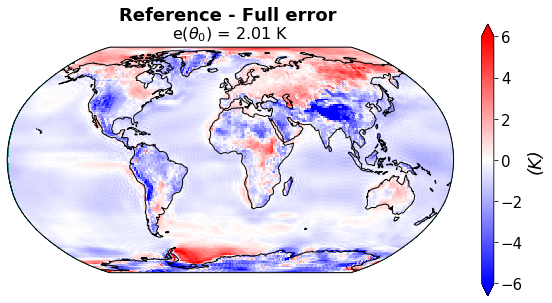

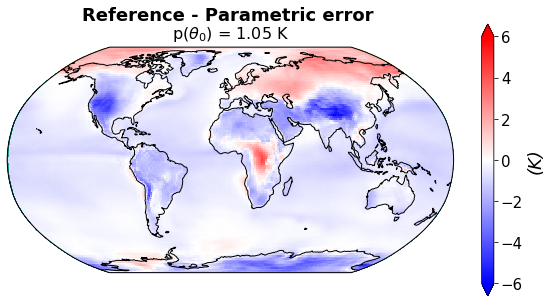

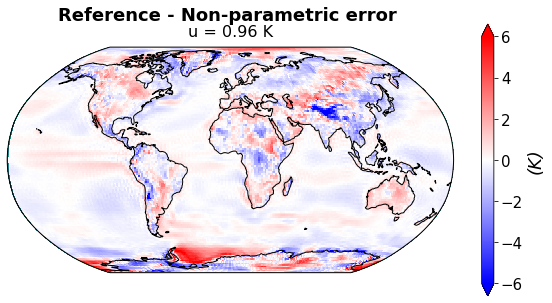

In [63]:
## -- full error e_p1 
dataset = e_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'

e_0 = around(e_p1,2)
units = 'K'   
title = 'Reference - Full error \n'
text_sup = 'e($\\theta_0$) = '+str(e_0)+' '+units[cpt]+'\n'

name_fig = 'Fig4_full_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, text_sup, name_fig)

## -- param error p_p1 
dataset = p_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'

e_0 = around(p_p1,2)
units = 'K'   
title = 'Reference - Parametric error \n'
text_sup = 'p($\\theta_0$) = '+str(e_0)+' '+units[cpt]+'\n'

name_fig = 'Fig4_param_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, text_sup, name_fig)

## -- non-param error u_p1 
dataset = u_diff_p1
var = dataset[:]
palette = "bwr"
xmin = -6
xmax = 6
label = '(K)'

e_0 = around(u_p1,2)
units = 'K'   
title = 'Reference - Non-parametric error \n'
text_sup = 'u = '+str(e_0)+' '+units[cpt]+'\n'

name_fig = 'Fig4_non-param_error_'+variable+'_p1.png'

plot_map(dataset, var, palette, xmin, xmax, label, title, text_sup, name_fig)

## CNRM-CM candidates 

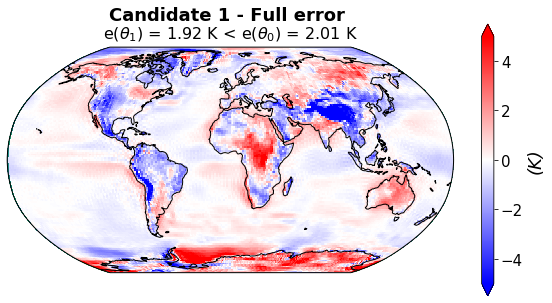

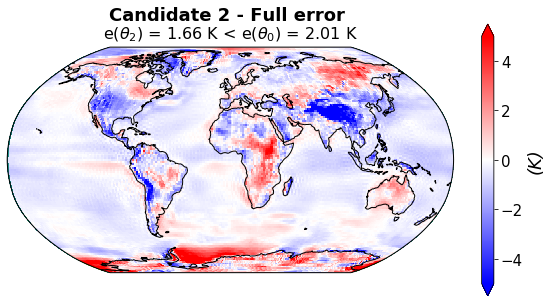

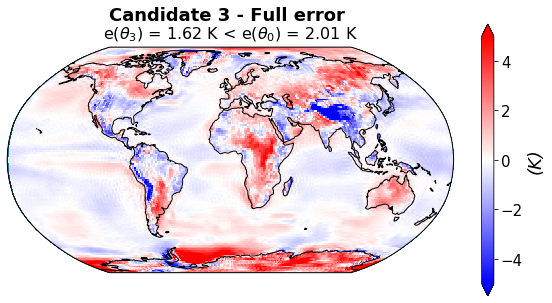

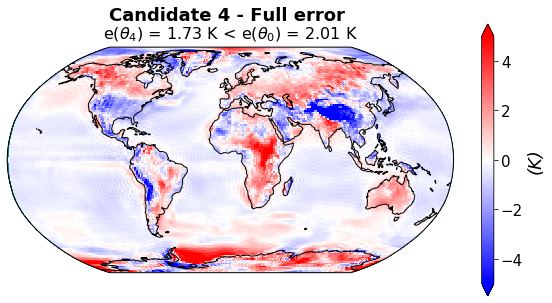

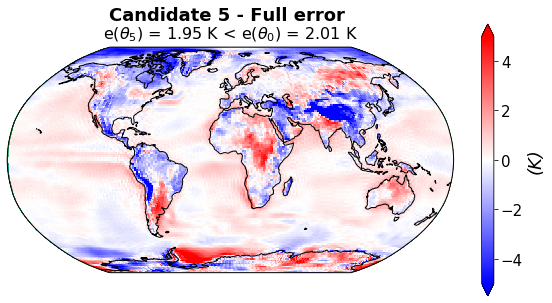

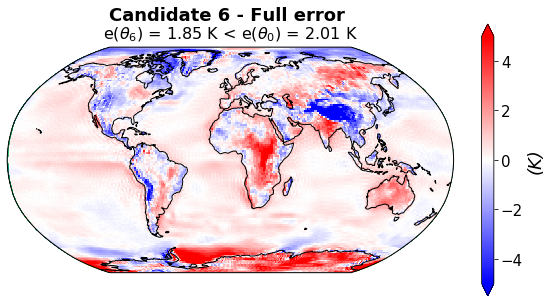

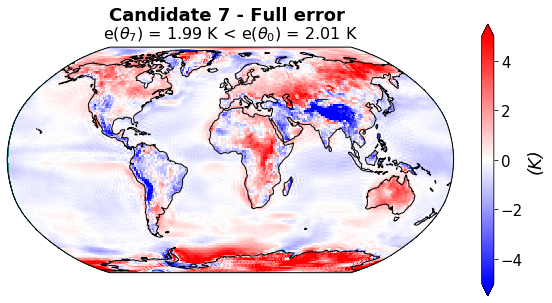

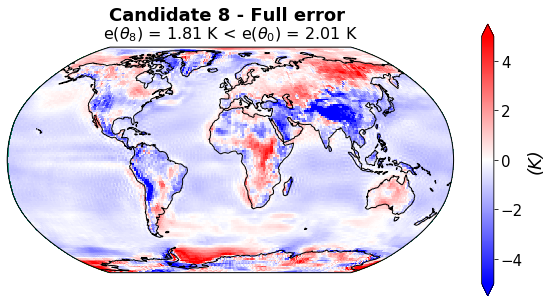

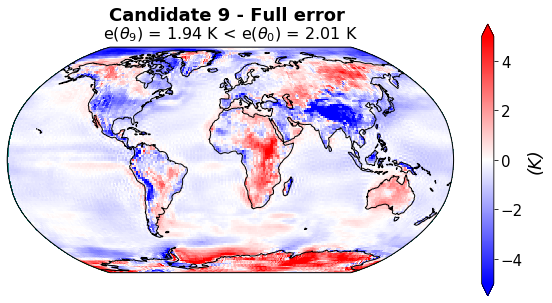

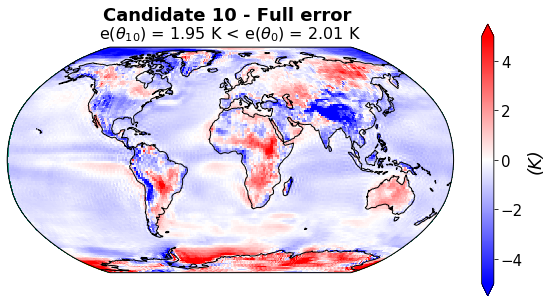

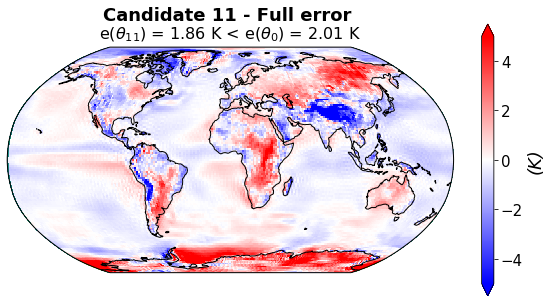

In [33]:
for i in range(0,len(e_sel),1) :
    dataset = e_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -5
    xmax = 5
    label = '(K)'
    
    e = float(e_sel_list[i].values.round(2))
    e_0 = around(e_p1,2)
    units = 'K'
    
    if e < e_0 :
            sign = '<'
    else :
            sign = '>'
    
    title = 'Candidate '+str(i+1)+' - Full error \n'
    text_sup = 'e($\\theta_{'+str(i+1)+'}$) = '+str(e)+' '+units[cpt]+' '+sign+' e($\\theta_0$) = '+str(e_0)+' '+units[cpt]+'\n'
    name_fig = 'Fig4_full_error_'+variable+'_candidate'+str(i+1)+'_rev.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, text_sup, name_fig)

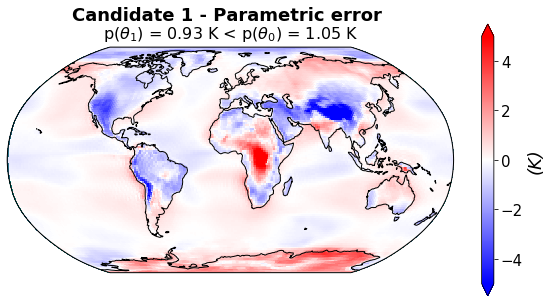

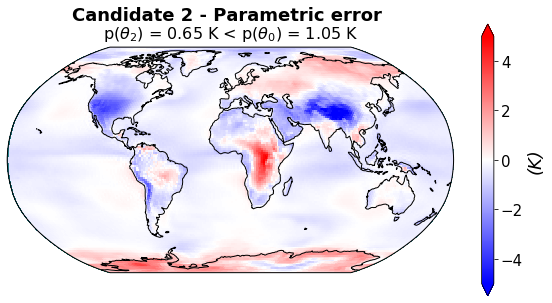

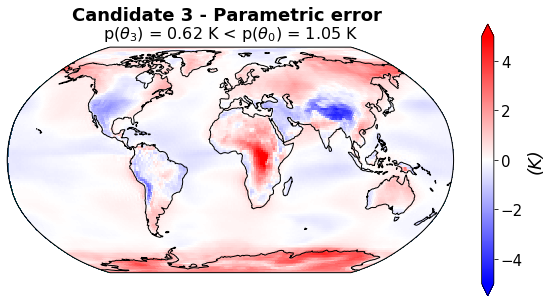

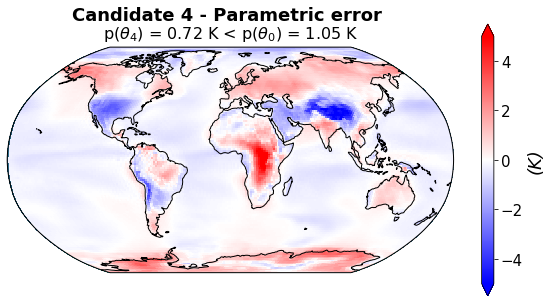

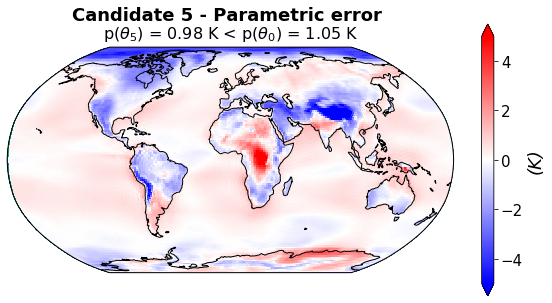

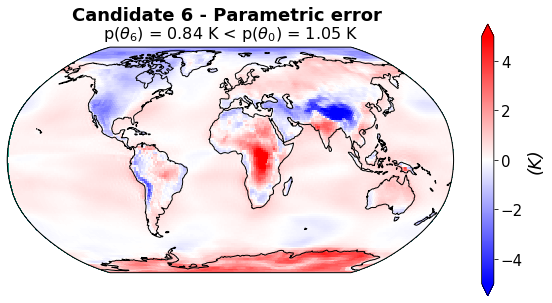

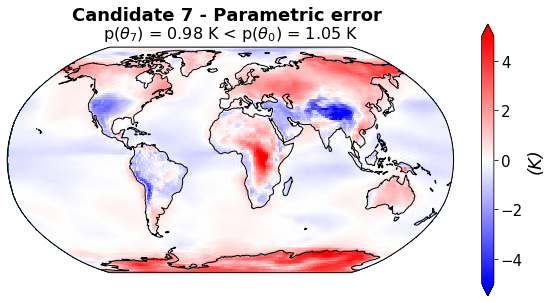

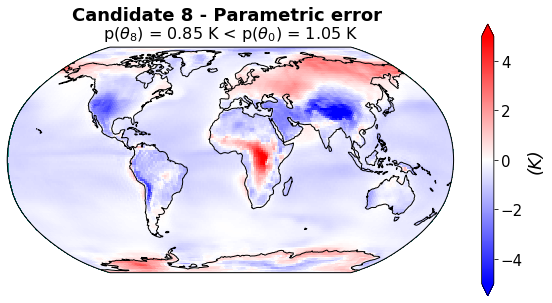

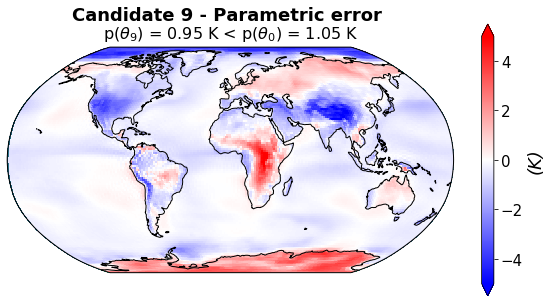

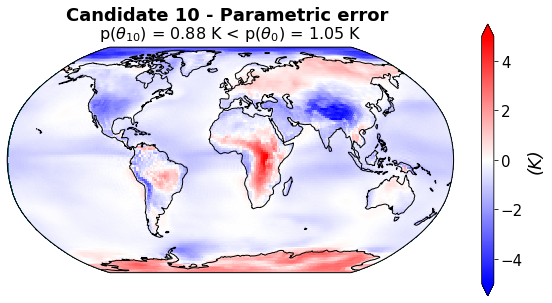

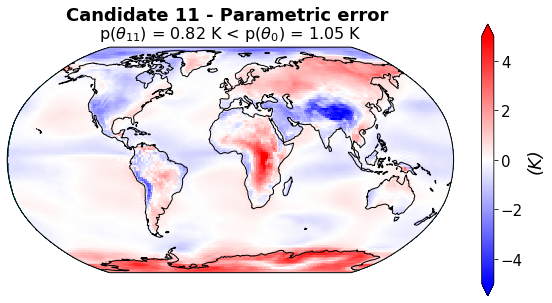

In [32]:
cpt=0
for i in range(0,len(e_sel),1) :
    dataset = p_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -5
    xmax = 5
    label = '(K)'
    name_fig = 'Fig4_param_error_'+variable+'_candidate'+str(i+1)+'_q18_rev.png'

    e = around(p_sel_list[i],2)
    e_0 = around(p_p1,2)
    units = 'K'
    
    if e < e_0 :
            sign = '<'
    else :
            sign = '>'
    
    title = 'Candidate '+str(i+1)+' - Parametric error \n'
    text_sup = 'p($\\theta_{'+str(i+1)+'}$) = '+str(e)+' '+units[cpt]+' '+sign+' p($\\theta_0$) = '+str(e_0)+' '+units[cpt]+'\n'
    name_fig = 'Fig4_param_error_'+variable+'_candidate'+str(i+1)+'_rev.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, text_sup, name_fig)

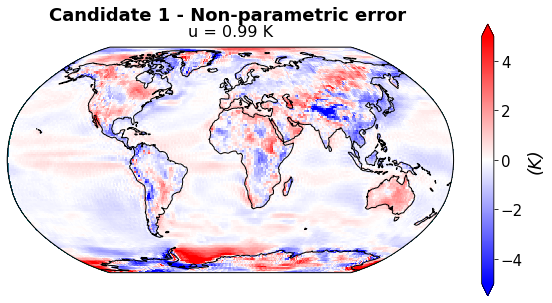

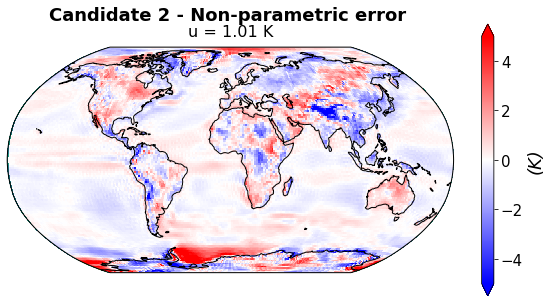

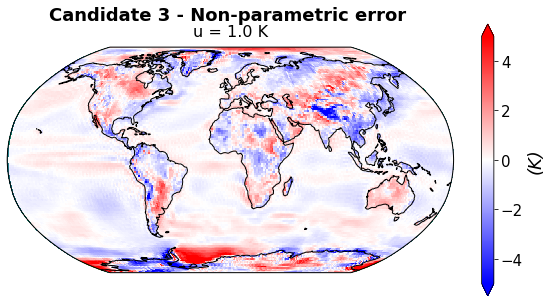

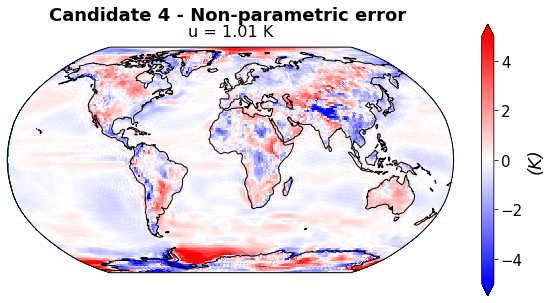

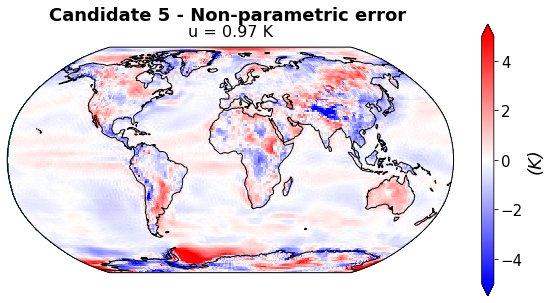

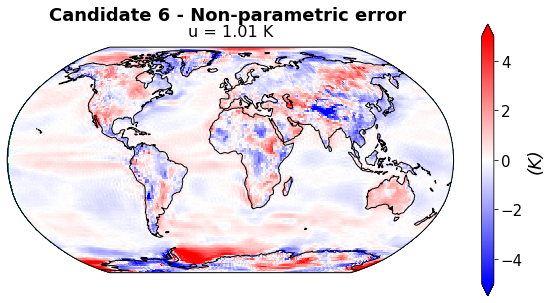

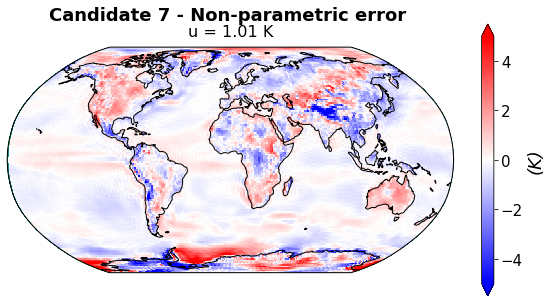

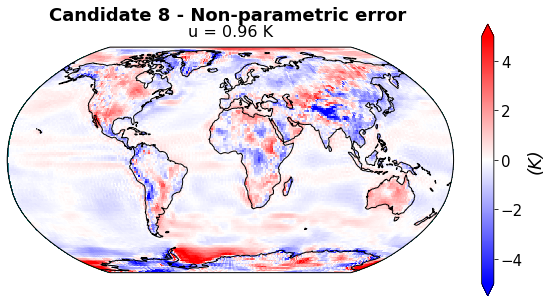

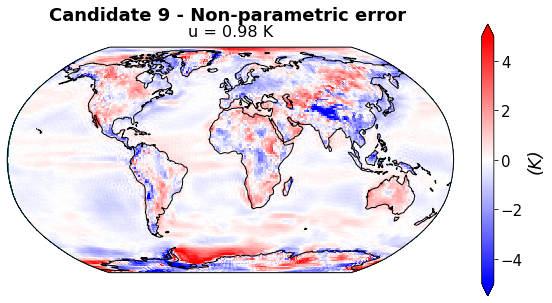

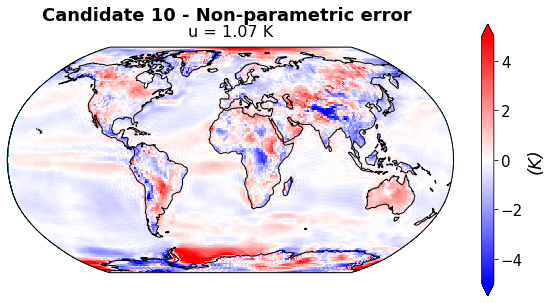

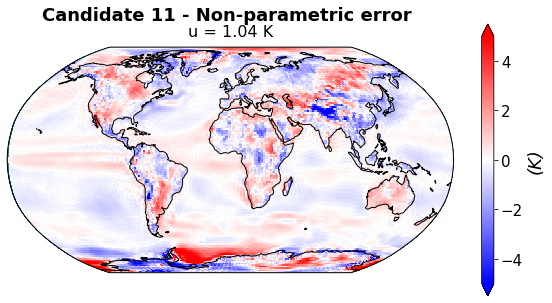

In [66]:
for i in range(0,len(e_sel),1) :
    dataset = u_diff[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -5
    xmax = 5
    label = '(K)'
    
    e_0 = around(u_sel[i],2)
    units = 'K'   
    title = 'Candidate '+str(i+1)+' - Non-parametric error \n'
    text_sup = 'u = '+str(e_0)+' '+units[cpt]+'\n'
    
    name_fig = 'Fig4_non-param_error_'+variable+'_candidate'+str(i+1)+'_q18_rev.png'
    plot_map(dataset, var, palette, xmin, xmax, label, title, text_sup, name_fig)

# Emulated candidates 

In [68]:
## -- Param. error 
p_diff_sel = []
p_emul = []
U_tmp = pc_cand_emul['pcs'].values
U = U_tmp[0:trunc]

for i in tqdm(range(0,len(e_sel),1)) :
    
    ## --Reconstruct 
    X_sel_rec = reconstruct_X(eofs_combined[0:trunc], pc=U[i], nb_dims=2)
        
    ## -- 3D p error [X_obs_rec - X_mod_rec]
    p_diff = diff_3D_rec(X_sel_rec, X_obs_rec, Mean, W_rmse_2D)
    p_diff_sel.append(p_diff)
    
    diff_tmp = p_diff**2 * W_rmse_2D
    p_emul_tmp = float(diff_tmp.sum(['lat', 'lon']))
    p_emul.append(p_emul_tmp)

100%|██████████| 11/11 [00:00<00:00, 167.12it/s]


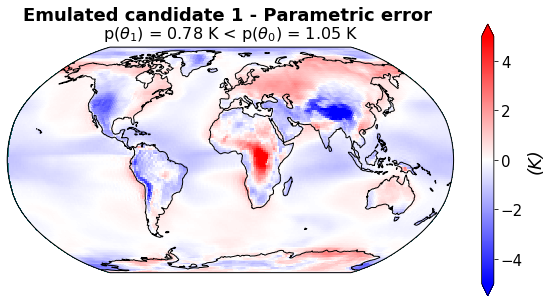

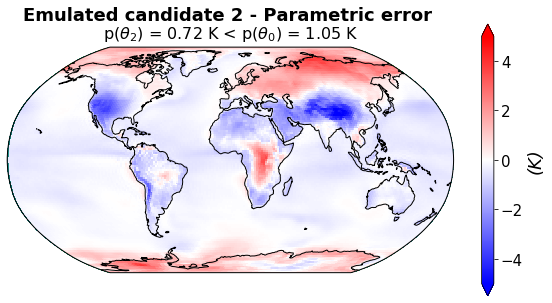

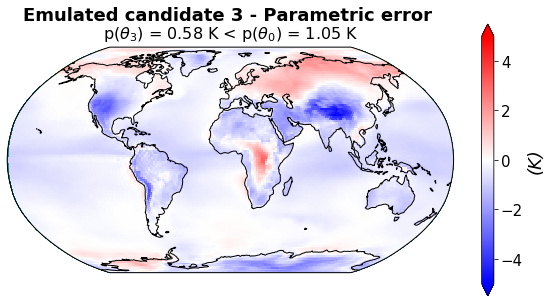

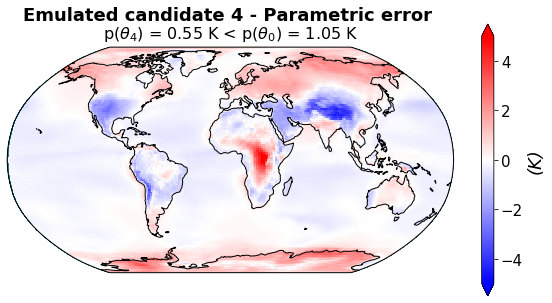

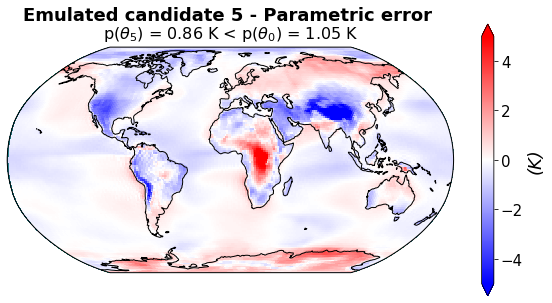

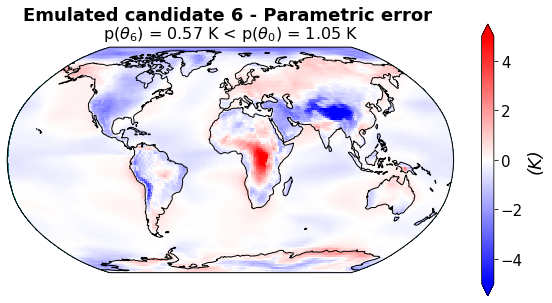

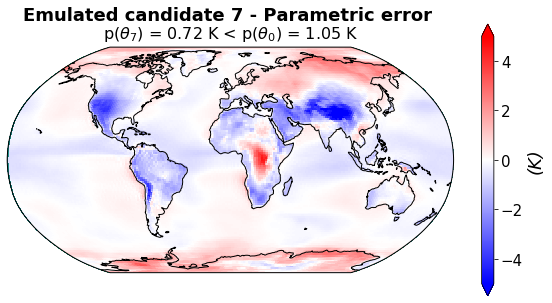

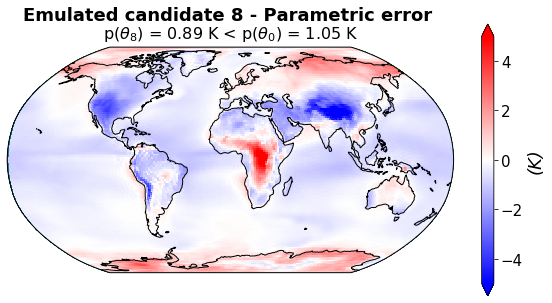

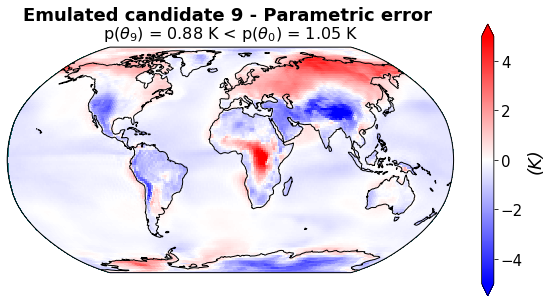

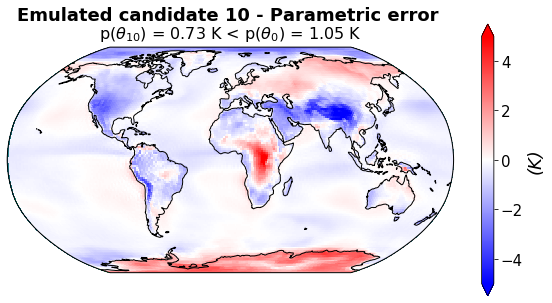

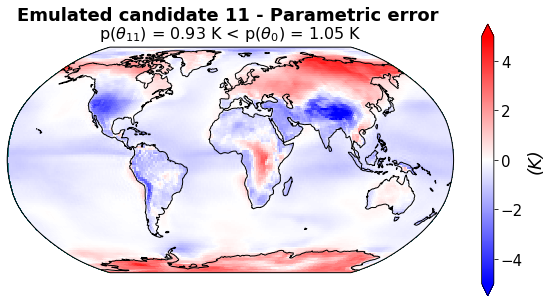

In [70]:
for i in range(0,len(p_diff_sel),1) :
    dataset = p_diff_sel[i]
    var = dataset[:]
    palette = "bwr"
    xmin = -5
    xmax = 5
    label = '(K)'
    
    e = around(p_emul[i],2)
    e_0 = around(p_p1,2)
    units = 'K'
    
    if e < e_0 :
            sign = '<'
    else :
            sign = '>'
    
    title = 'Emulated candidate '+str(i+1)+' - Parametric error \n'
    text_sup = 'p($\\theta_{'+str(i+1)+'}$) = '+str(e)+' '+units[cpt]+' '+sign+' p($\\theta_0$) = '+str(e_0)+' '+units[cpt]+'\n'
    
    name_fig = 'Fig4_param_error_'+variable+'_emul_candidate'+str(i+1)+'_q18_rev.png'

    plot_map(dataset, var, palette, xmin, xmax, label, title, text_sup, name_fig)